# FIT5202: Data processing for big data

## Assignment 2B: Real-time stream processing on big data

### Task 3: Streaming application using Spark Structured Streaming 


**1. Initialise the spark session:**


In [1]:
from pyspark import SparkConf


# spark to run on two threads
master = "local[2]"
# application name
app_name = "Spark Structured Streaming for flights-delay data"
# spark configuration
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.sql.session.timeZone","UTC")
from pyspark.sql import SparkSession # Spark SQL

# SparkContext and SparkSession 
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql import functions as F
from pyspark.sql.types import *

spark = SparkSession \
    .builder \
    .appName("Spark Structured Streaming for flights-delay data") \
    .getOrCreate()


**2. Ingest streaming data from kafka producer in task 1:**

In [2]:
topic = "flightTopic"
df_flightRecords= spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", topic) \
    .load()

df_flightRecords.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)




**3. Transform streaming data into proper format:**

In [3]:
df_flightRecords = df_flightRecords.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)")

In [5]:
query = df_flightRecords \
    .writeStream \
    .outputMode("append") \
    .format("console") \
    .trigger(processingTime='5 seconds') \
    .start()

In [7]:
query.stop()

**Update the parsed value for each column:**

In [8]:
#Schema of the data from metadata file
schema_flightRecords = StructType([
    StructField("YEAR", LongType(), True),
    StructField("MONTH", LongType(), True),
    StructField("DAY", LongType(), True),
    StructField("DAY_OF_WEEK", LongType(), True),
    StructField("AIRLINE", StringType(), True),
    StructField("FLIGHT_NUMBER", LongType(), True),
    StructField("TAIL_NUMBER", StringType(), True),
    StructField("ORIGIN_AIRPORT", StringType(), True),
    StructField("DESTINATION_AIRPORT", StringType(), True),
    StructField("SCHEDULED_DEPARTURE", LongType(), True),
    StructField("DEPARTURE_TIME", LongType(), True),
    StructField("DEPARTURE_DELAY", LongType(), True),
    StructField("TAXI_OUT", LongType(), True),
    StructField("WHEELS_OFF", LongType(), True),
    StructField("SCHEDULED_TIME", LongType(), True),
    StructField("ELAPSED_TIME", LongType(), True),
    StructField("AIR_TIME", LongType(), True),
    StructField("DISTANCE", LongType(), True),
    StructField("TAXI_IN", LongType(), True),
    StructField("SCHEDULED_ARRIVAL", LongType(), True),
    StructField("ARRIVAL_TIME", LongType(), True),
    StructField("ARRIVAL_DELAY", LongType(), True),
    StructField("DIVERTED", LongType(), True),
    StructField("CANCELLED", LongType(), True),
    StructField("ts", LongType(), True)])

#parse the data
df_flightRecords_parsed = df_flightRecords.select(F.from_json(F.col("value").cast("string"), schema_flightRecords).alias('parsed_value'))


#Formatted data
df_flightRecords_formatted = df_flightRecords_parsed.select(
    F.col("parsed_value.YEAR").alias("YEAR"),
    F.col("parsed_value.MONTH").alias("MONTH"),
    F.col("parsed_value.DAY").alias("DAY"),
    F.col("parsed_value.DAY_OF_WEEK").alias("DAY_OF_WEEK"),
    F.col("parsed_value.AIRLINE").alias("AIRLINE"),
    F.col("parsed_value.FLIGHT_NUMBER").alias("FLIGHT_NUMBER"),
    F.col("parsed_value.TAIL_NUMBER").alias("TAIL_NUMBER"),
    F.col("parsed_value.ORIGIN_AIRPORT").alias("ORIGIN_AIRPORT"),
    F.col("parsed_value.DESTINATION_AIRPORT").alias("DESTINATION_AIRPORT"),
    F.col("parsed_value.SCHEDULED_DEPARTURE").alias("SCHEDULED_DEPARTURE"),
    F.col("parsed_value.DEPARTURE_TIME").alias("DEPARTURE_TIME"),
    F.col("parsed_value.DEPARTURE_DELAY").alias("DEPARTURE_DELAY"),
    F.col("parsed_value.TAXI_OUT").alias("TAXI_OUT"),
    F.col("parsed_value.WHEELS_OFF").alias("WHEELS_OFF"),
    F.col("parsed_value.SCHEDULED_TIME").alias("SCHEDULED_TIME"),
    F.col("parsed_value.ELAPSED_TIME").alias("ELAPSED_TIME"),
    F.col("parsed_value.AIR_TIME").alias("AIR_TIME"),
    F.col("parsed_value.DISTANCE").alias("DISTANCE"),
    F.col("parsed_value.TAXI_IN").alias("TAXI_IN"),
    F.col("parsed_value.SCHEDULED_ARRIVAL").alias("SCHEDULED_ARRIVAL"),
    F.col("parsed_value.ARRIVAL_TIME").alias("ARRIVAL_TIME"),
    F.col("parsed_value.ARRIVAL_DELAY").alias("ARRIVAL_DELAY"),
    F.col("parsed_value.DIVERTED").alias("DIVERTED"),
    F.col("parsed_value.CANCELLED").alias("CANCELLED"),
    F.col("parsed_value.ts").alias("ts"))

**4. Persist the transformed streaming data in parquet format:**

In [9]:
query_parquet_flightRecords = df_flightRecords_formatted.writeStream.format("parquet")\
        .outputMode("append")\
        .option("path", "/home/student/Desktop/Assignment_2B/uaro0001")\
        .option("checkpointLocation", "/home/student/Desktop/Assignment_2B/uaro0001")\
        .start()

In [10]:
query_parquet_flightRecords.stop()

**5. Load the Machine Learning model:**

In this task the model development for departure class is choosen to be implemented.

Using the model provided, additional columns 'DEPT_TIME_FLAG' and '' are required as created in the 'Step01OverallProcessInGeneratingTheModel' of the given model development folder so these columns are to be added

In [27]:
print(df_flightRecords_formatted)

DataFrame[YEAR: bigint, MONTH: bigint, DAY: bigint, DAY_OF_WEEK: bigint, AIRLINE: string, FLIGHT_NUMBER: bigint, TAIL_NUMBER: string, ORIGIN_AIRPORT: string, DESTINATION_AIRPORT: string, SCHEDULED_DEPARTURE: bigint, DEPARTURE_TIME: bigint, DEPARTURE_DELAY: bigint, TAXI_OUT: bigint, WHEELS_OFF: bigint, SCHEDULED_TIME: bigint, ELAPSED_TIME: bigint, AIR_TIME: bigint, DISTANCE: bigint, TAXI_IN: bigint, SCHEDULED_ARRIVAL: bigint, ARRIVAL_TIME: bigint, ARRIVAL_DELAY: bigint, DIVERTED: bigint, CANCELLED: bigint, ts: bigint, DEPT_TIME_FLAG: string, binaryDeptDelay: int]


In [11]:
#Categorical column 'DEPT_TIME_FLAG' 
df_flightRecords_formatted = df_flightRecords_formatted.withColumn('DEPT_TIME_FLAG', F.when(df_flightRecords_formatted.SCHEDULED_DEPARTURE < 500, "midnight")\
.when(((df_flightRecords_formatted.SCHEDULED_DEPARTURE >= 500) & (df_flightRecords_formatted.SCHEDULED_DEPARTURE <= 1100) ), " Morning")\
.when(((df_flightRecords_formatted.SCHEDULED_DEPARTURE >= 1100) & (df_flightRecords_formatted.SCHEDULED_DEPARTURE <= 1600) ), " Afternoon")\
.when(((df_flightRecords_formatted.SCHEDULED_DEPARTURE >= 1600) & (df_flightRecords_formatted.SCHEDULED_DEPARTURE <= 2000) ), " Evening")\
.otherwise("Night"))

#binaryDeptDelay
df_flightRecords_formatted = df_flightRecords_formatted.withColumn('binaryDeptDelay', F.when(df_flightRecords_formatted.DEPARTURE_DELAY < 0, 0).otherwise(1))


In [12]:
import zipfile
from pyspark.ml import PipelineModel

#Extract the model from zip file
with zipfile.ZipFile("Model.zip","r") as zip_ref:
    zip_ref.extractall("/home/student/Desktop/Assignment_2B/uaro0001/Model")
    
#load the dept model
model_flights = PipelineModel.load('/home/student/Desktop/Assignment_2B/uaro0001/Model/Dept')   

#transform the model on formatted data
piplined_model = model_flights.transform(df_flightRecords_formatted)

**6. Using the classification results:**

**6.1: Filter out the data for keys 1, 2 and 3 only**

In [13]:
df_predicted_flightRecords = piplined_model.filter((piplined_model['DAY_OF_WEEK'] == 1) | (piplined_model['DAY_OF_WEEK'] == 2) | (piplined_model['DAY_OF_WEEK'] == 3))

In [14]:
df_predicted_final = df_predicted_flightRecords \
    .groupBy('DAY_OF_WEEK', 'ts')\
    .agg(F.count("FLIGHT_NUMBER").alias("total_count"))\
    .select("DAY_OF_WEEK","ts","total_count")

In [21]:
query = df_predicted_final \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("predicted_final_sql")\
    .trigger(processingTime='10 seconds') \
    .start()

In [22]:
spark.sql("select * from predicted_final_sql").show()

+-----------+---+-----------+
|DAY_OF_WEEK| ts|total_count|
+-----------+---+-----------+
+-----------+---+-----------+



In [25]:
query.stop()

In [23]:
#intialise plots
def init_plots():
    try:
        width = 9.5
        height = 6
        #create figure
        fig = plt.figure(figsize=(width,height)) 
        fig.subplots_adjust(hspace=0.8)
        #add subplot to axes
        ax = fig.add_subplot(111) 
        #set labels
        ax.set_xlabel('Time')
        ax.set_ylabel('Count')
        #title axis
        ax.title.set_text('Time Vs Count')
        #plot title
        fig.suptitle('Real-time uniform stream data visualization') 
        #display plot
        fig.show() 
        #draw on canvas
        fig.canvas.draw() 
        
        return fig, ax
    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


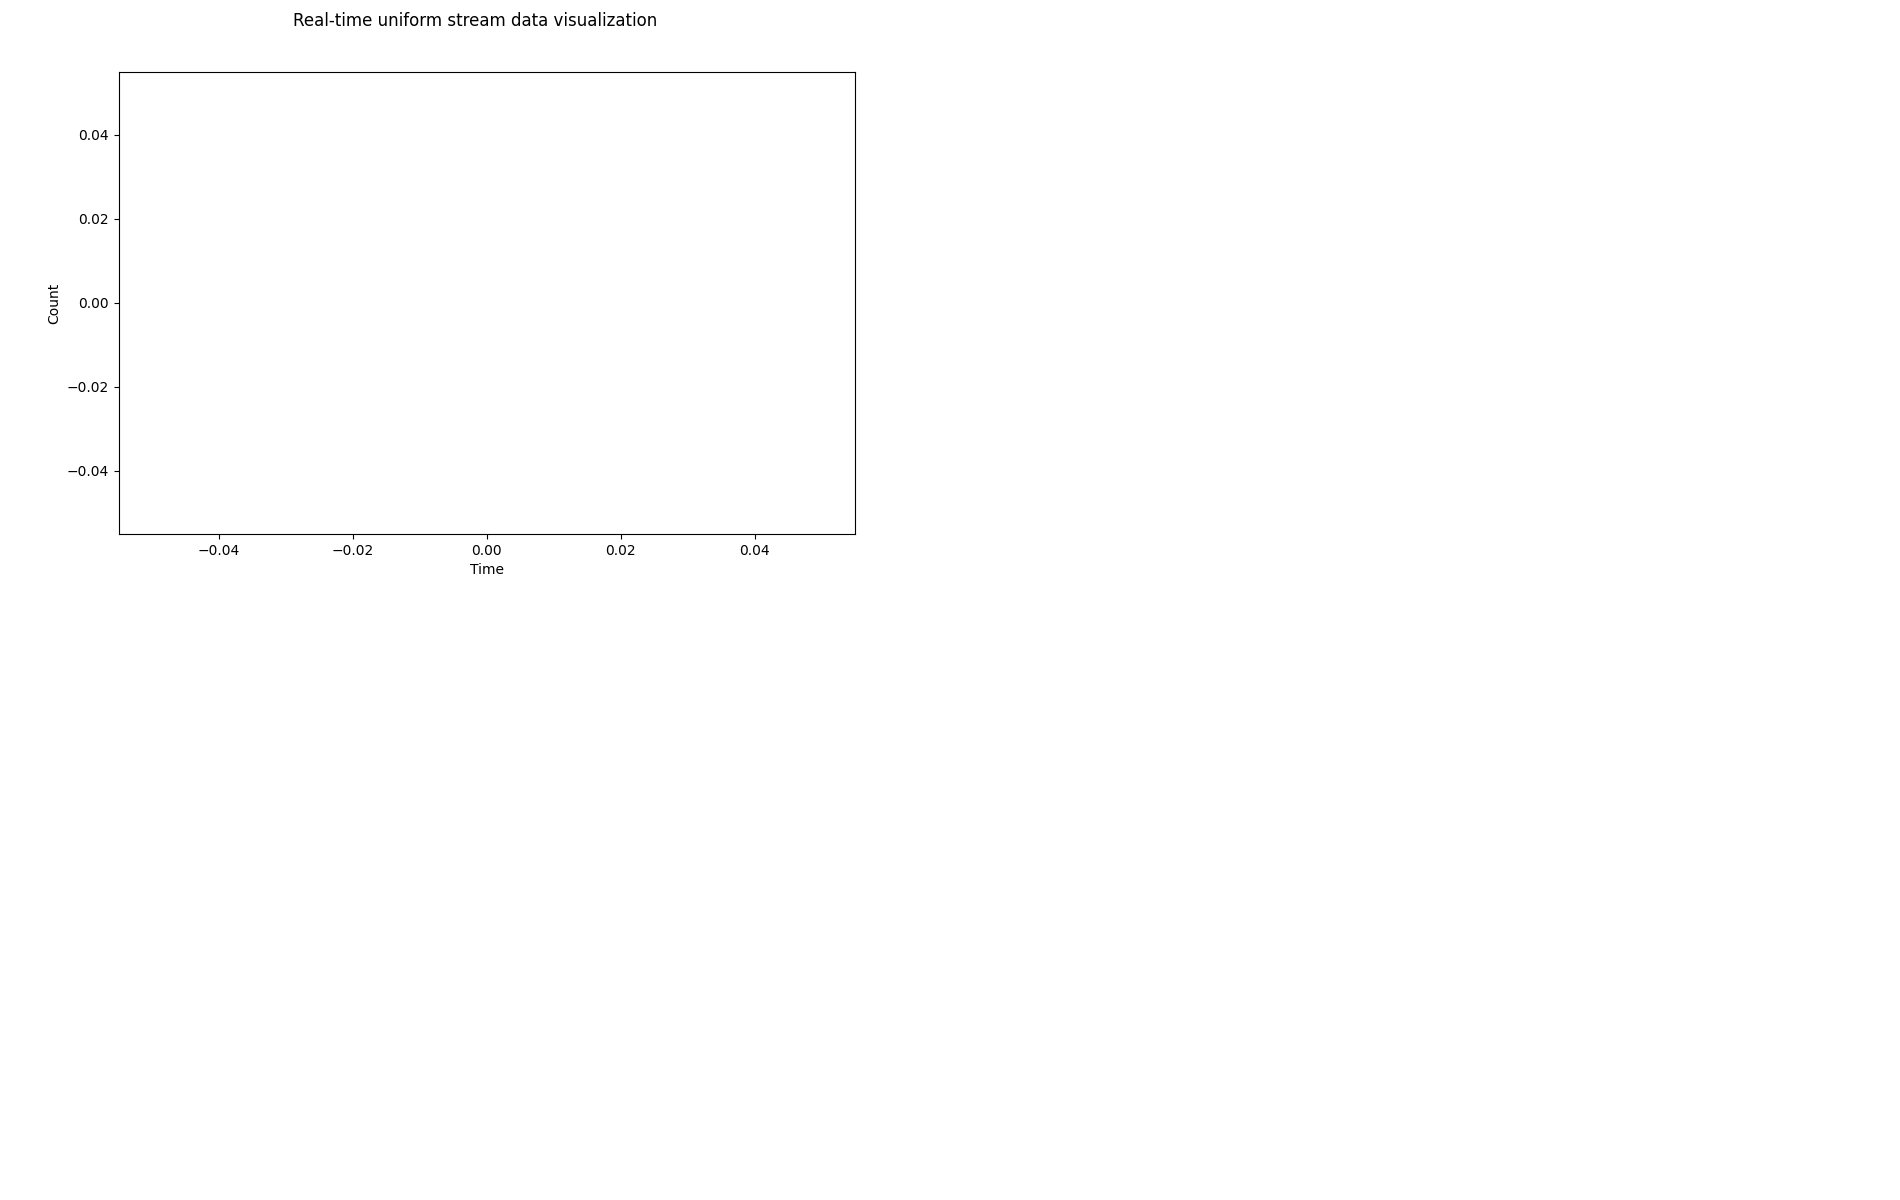

KeyboardInterrupt: 

In [28]:
import time
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax = init_plots() #initialise plots

keys = [1,2,3] #flightKeys

while True:
    
    df = spark.sql("select * from predicted_final_sql order by ts desc").toPandas() #get data
    
    #for each key value
    for i in keys:
        new_df = df[df['DAY_OF_WEEK']==i]
        x = new_df['ts'].to_list() #x label value
        y = new_df['total_count'].to_list() #y label value
        ax.plot(x, y)
        ax.set_xlabel('Time') 
        ax.set_ylabel('Count')
        fig.canvas.draw()
    ax.clear()
    time.sleep(10)
    